# Модули и библиотеки

In [25]:
from oracles import BinaryLogistic
from optimization import *
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid")
%config InlineBackend.figure_format = 'svg'

In [26]:
train_f = pd.read_csv('toxic_train.csv')
test_f = pd.read_csv('toxic_test.csv')

# Обработка данных

In [27]:
X_train = train_f.drop('is_toxic', axis=1)
y_train = train_f.is_toxic.values
X_test = test_f.drop('is_toxic', axis=1)
y_test = test_f.is_toxic.values
y_train = np.where(y_train, 1, -1)
y_test = np.where(y_test, 1, -1)

In [28]:
X_train_upd = X_train.apply(lambda x: x.str.lower() if x.dtype == 'O' else x)
X_train_upd = X_train_upd.apply(lambda col: col.map(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x) if isinstance(x, str) else x))
X_train_upd = X_train_upd.fillna(' ')
X_test_upd = X_test.apply(lambda x: x.str.lower() if x.dtype == 'O' else x)
X_test_upd = X_test_upd.apply(lambda col: col.map(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x) if isinstance(x, str) else x))
X_test_upd = X_test_upd.fillna(' ')
train_comment = X_train_upd['comment_text']
test_comment = X_test_upd['comment_text']

In [29]:
train_comment

0        explanation why the edits made under my userna...
1        d aww  he matches this background colour i m s...
2        hey man  i m really not trying to edit war  it...
3          more i can t make any real suggestions on im...
4        you  sir  are my hero  any chance you remember...
                               ...                        
52056        our previous conversation   you fucking sh...
52057                    you are a mischievious pubic hair
52058    your absurd edits   your absurd edits on great...
52059       hey listen don t you ever     delete my edi...
52060    and i m going to keep posting the stuff u dele...
Name: comment_text, Length: 52061, dtype: object

In [30]:
test_comment

0        thank you for understanding  i think very high...
1                          dear god this site is horrible 
2             somebody will invariably try to add relig...
3             it says it right there that it is a type ...
4                before adding a new product to the lis...
                               ...                        
20671                            nigel is a crazy idiot   
20672             well  now don t i feel stupid           
20673      fourth baldrick possibly being cleverer than...
20674            iran      that s right  iran  it was o...
20675    mel gibson is a nazi bitch who makes shitty mo...
Name: comment_text, Length: 20676, dtype: object

# Преобразование выборки

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0.001) 
X_train = vectorizer.fit_transform(train_comment)
vectorizer.fit(train_comment)
X_test = vectorizer.transform(test_comment)


In [32]:
X_train.shape

(52061, 3736)

In [33]:
X_test.shape

(20676, 3736)

Нормализация выборки

In [34]:
from sklearn.preprocessing import normalize

X_train = normalize(X_train, norm='l2', axis=1)
X_test = normalize(X_test, norm='l2', axis=1)

# Сравнение численного и аналитического вычисления градиентов

Импортируем:
* функцию численного подсчёта градиента
* логарифмическую функцию потерь
* аналитически вычисленный её градиент

In [509]:
def grad_finite_diff(function, w, X, y, eps=1e-8):
    eye = np.eye(len(w))


    def compute_perturbed_grad(w_i):
        perturbed_w = w + eps * w_i 
        return (function(X, y, perturbed_w) - function(X, y, w)) / eps
    
    result = np.apply_along_axis(compute_perturbed_grad, axis=1, arr=eye)
    return result

In [510]:
from oracles import BinaryLogistic

In [511]:
np.random.seed(153)
objects = 50000
features = [10, 50, 100, 250, 400, 500, 750, 1000]
l2 = np.random.rand()

In [514]:
loss = BinaryLogistic(l2)
func = loss.func
time_proc_num = []
time_proc_an = []
diff = []
for i in range(len(features)):
    X = np.random.random((objects, features[i]))
    y = np.random.choice([-1, 1], size=objects)
    w = np.random.random(features[i])
    batch_num = []
    batch_an = []
    batch_diff = []
    for j in range(3):
        now_time = time.time()
        grad_num = grad_finite_diff(func, w, X, y)
        batch_num.append(time.time() - now_time)
        now_time = time.time()
        grad_an = loss.grad(X, y, w)
        batch_an.append(time.time() - now_time)
        batch_diff.append(abs(grad_an - grad_num))
    time_proc_num.append(np.mean(batch_num))
    time_proc_an.append(np.mean(batch_an))
    diff.append(np.mean(batch_diff))

In [52]:
time_proc_num

[0.06266180674235027,
 0.4865709145863851,
 1.0917030175526936,
 6.2946239312489825,
 12.532109340031942,
 19.324439843495686,
 43.9162171681722,
 71.95990204811096]

In [53]:
time_proc_an

[0.0043345292409261065,
 0.009959697723388672,
 0.012309948603312174,
 0.027594725290934246,
 0.032582998275756836,
 0.042722066243489586,
 0.06400028864542644,
 0.07186094919840495]

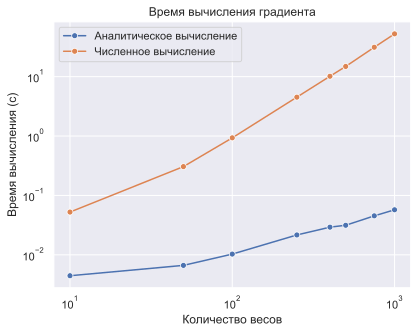

In [513]:
sns.lineplot(x=features, y=time_proc_an, label='Аналитическое вычисление', marker='o')
sns.lineplot(x=features, y=time_proc_num, label='Численное вычисление', marker='o')
plt.title("Время вычисления градиента")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Количество весов")
plt.ylabel("Время вычисления (с)")
plt.savefig('an_vs_num2.pdf')
plt.show()

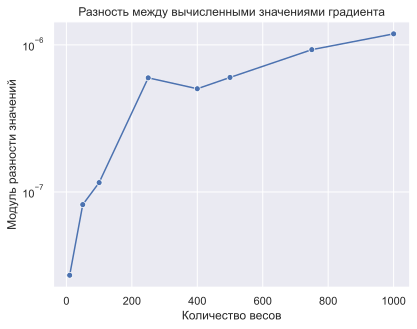

In [55]:
x = np.array(diff)
# x = x**2
sns.lineplot(x=features, y=x, marker='o')
plt.title("Разность между вычисленными значениями градиента")
plt.yscale('log')
plt.xlabel("Количество весов")
plt.ylabel("Модуль разности значений")
plt.savefig('diff_an_num1.pdf')
plt.show()

# Поведение градиентного спуска для задачи логистической регрессии

## Подбор step_alpha

In [40]:
alpha = np.arange(0, 1, 0.4)
alpha = np.append(alpha, [2, 5, 10, 20, 50, 70, 90, 100])
all_history = []
for i in range(len(alpha)):
    gdc = GDClassifier(step_alpha=alpha[i])
    all_history.append(gdc.fit(X_train, y_train, w_0 = np.zeros(X_train.shape[1]), trace=True, X_test=X_test, y_test=y_test))

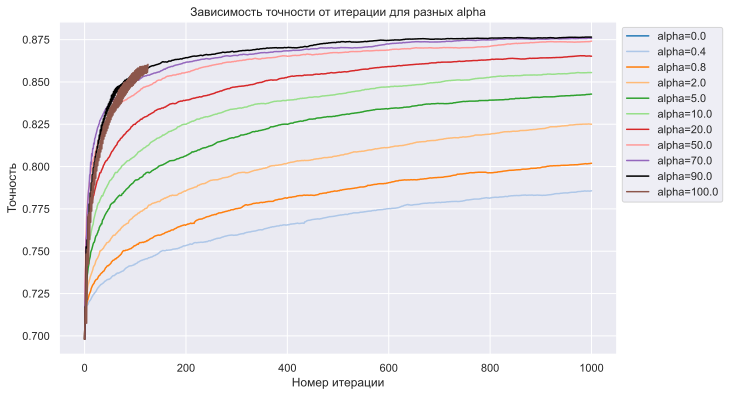

In [41]:
colors = sns.color_palette("tab20", len(alpha))
colors[len(alpha)-2] = 'black'
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(alpha)):
    sns.lineplot(x=range(0, len(all_history[i]['accuracy'])), y=all_history[i]['accuracy'], label=('alpha=' + "%.1f" % alpha[i]), color=colors[i])
plt.title("Зависимость точности от итерации для разных alpha")
plt.xlabel("Номер итерации")
plt.ylabel("Точность")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('gd_alpha_acc.pdf', bbox_inches="tight")
plt.show()

In [42]:
all_history[-3]['accuracy'][-1]

0.8757496614432192

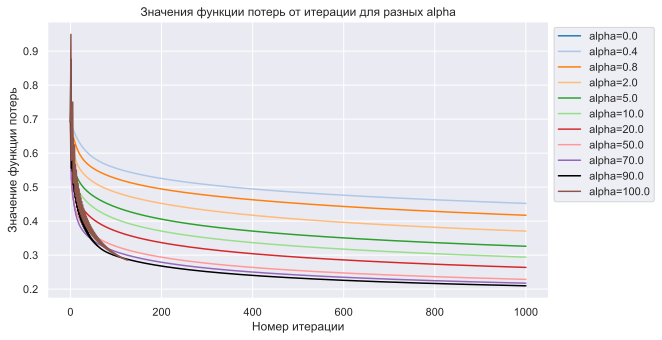

In [43]:
fig = plt.figure(figsize=(9, 5))
for i in range(0, len(alpha)):
    sns.lineplot(x=range(0, len(all_history[i]['func'])), y=all_history[i]['func'], label=('alpha=' + "%.1f" % alpha[i]), color=colors[i])
plt.title("Значения функции потерь от итерации для разных alpha")
plt.xlabel("Номер итерации")
plt.ylabel("Значение функции потерь")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('gd_alpha_func.pdf', bbox_inches="tight")
plt.show()

## Подбор step_betta

In [44]:
beta = np.arange(0, 1.5, 0.1)
beta = np.append(beta, [3, 5, 10])
all_history2 = []
for i in range(len(beta)):
    gdc = GDClassifier(step_beta=beta[i])
    all_history2.append(gdc.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True, X_test=X_test, y_test=y_test))

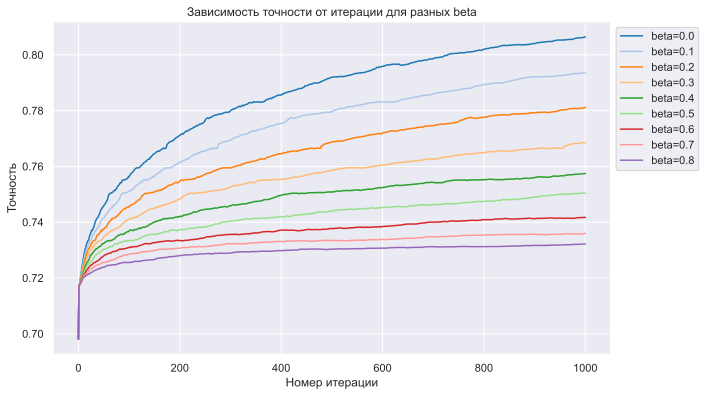

In [45]:
colors2 = sns.color_palette("tab20", len(beta))
colors2[len(beta)-3] = 'black'
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(beta) - 9):
    sns.lineplot(x=range(0, len(all_history2[i]['accuracy'])), y=all_history2[i]['accuracy'], label=('beta=' + "%.1f" % beta[i]), color=colors2[i])
plt.title("Зависимость точности от итерации для разных beta")
plt.xlabel("Номер итерации")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel("Точность")
plt.savefig('gd_beta_acc1.pdf', bbox_inches="tight")
plt.show()

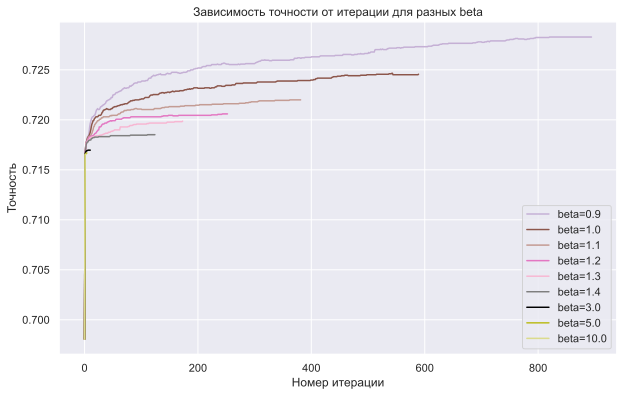

In [46]:
fig = plt.figure(figsize=(10, 6))
for i in range(len(beta) - 9, len(beta)):
    sns.lineplot(x=range(0, len(all_history2[i]['accuracy'])), y=all_history2[i]['accuracy'], label=('beta=' + "%.1f" % beta[i]), color=colors2[i])
plt.title("Зависимость точности от итерации для разных beta")
plt.xlabel("Номер итерации")
plt.ylabel("Точность")
plt.savefig('gd_beta_acc2.pdf', bbox_inches="tight")
plt.show()

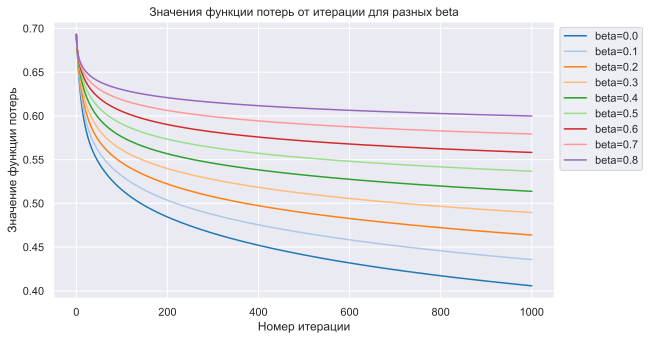

In [47]:
fig = plt.figure(figsize=(9, 5))
for i in range(0, len(beta)-9):
    sns.lineplot(x=range(0, len(all_history2[i]['func'])), y=all_history2[i]['func'], label=('beta=' + "%.1f" % beta[i]), color=colors2[i])
plt.title("Значения функции потерь от итерации для разных beta")
plt.xlabel("Номер итерации")
plt.ylabel("Значение функции потерь")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('gd_beta_func1.pdf', bbox_inches="tight")
plt.show()

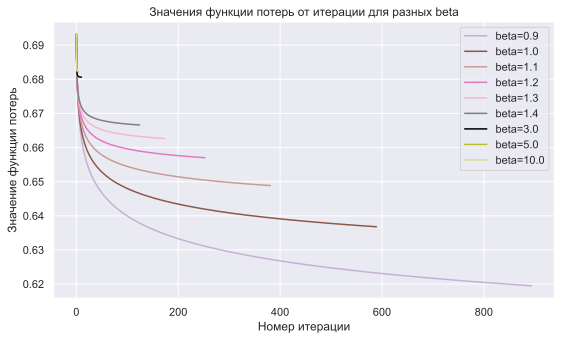

In [48]:
fig = plt.figure(figsize=(9, 5))
for i in range(len(beta) - 9, len(beta)):
    sns.lineplot(x=range(0, len(all_history2[i]['func'])), y=all_history2[i]['func'], label=('beta=' + "%.1f" % beta[i]), color=colors2[i])
plt.title("Значения функции потерь от итерации для разных beta")
plt.xlabel("Номер итерации")
plt.ylabel("Значение функции потерь")
plt.savefig('gd_beta_func2.pdf', bbox_inches="tight")
plt.show()

## Подбор начального приближения

In [101]:
def initialize_weights_normal(D, sigma=0.1):
    return np.random.normal(loc=0.0, scale=sigma, size=D)


def initialize_weights_uniform(D, epsilon=0.1):
    return np.random.uniform(low=-epsilon, high=epsilon, size=D)

In [102]:
D = X_train.shape[1]
w_0 = []
w_0.append(np.zeros(D))
w_0.append(initialize_weights_normal(D, np.sqrt(1 / D))) 
# w_0.append(initialize_weights_normal(D, 0.01)) 
w_0.append(initialize_weights_normal(D, 0.05))
w_0.append(initialize_weights_normal(D, 0.1))
w_0.append(initialize_weights_uniform(D, np.sqrt(1 / D)))
# w_0.append(initialize_weights_uniform(D, 0.01))
w_0.append(initialize_weights_uniform(D, 0.05))
w_0.append(initialize_weights_uniform(D, 0.1)) 
labels = ['zeros', 'norm(0, sqrt(1/D))', 'norm(0, 0.5)', 'norm(0, 0.1)', 
          'uni(sqrt(1/D))', 'uni(0.05)', 'uni(0.1)']

In [103]:
np.array(w_0[1]).shape

(3736,)

In [109]:
all_history_w = []
for i in range(len(w_0)):
    gdc = GDClassifier()
    all_history_w.append(gdc.fit(X_train, y_train, w_0=w_0[i], trace=True, X_test=X_test, y_test=y_test))

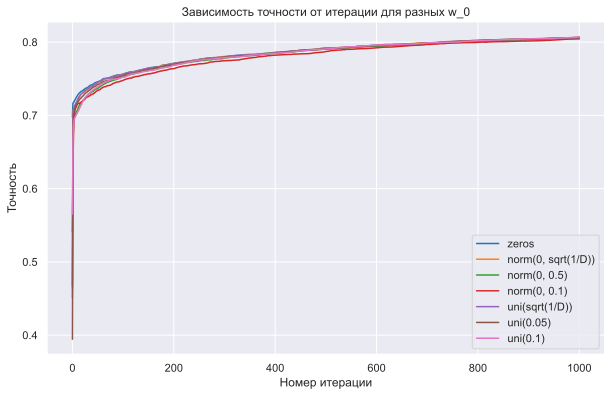

In [110]:
colors3 = sns.color_palette("tab10", len(w_0))
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(w_0)):
    sns.lineplot(x=range(0, len(all_history_w[i]['accuracy'])), y=all_history_w[i]['accuracy'], label=labels[i], color=colors3[i])
plt.title("Зависимость точности от итерации для разных w_0")
plt.xlabel("Номер итерации")
plt.ylabel("Точность")
plt.savefig('gd_w_acc1.pdf')
plt.show()

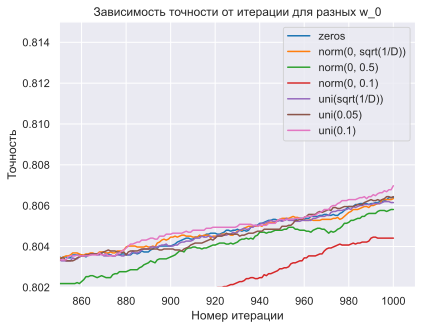

In [111]:
# fig = plt.figure(figsize=(10, 6))
for i in range(0, len(w_0)):
    sns.lineplot(x=range(0, len(all_history_w[i]['accuracy'])), y=all_history_w[i]['accuracy'], label=labels[i], color=colors3[i])
plt.title("Зависимость точности от итерации для разных w_0")
plt.xlabel("Номер итерации")
plt.ylabel("Точность")
plt.ylim(0.802, 0.815) 
plt.xlim(850, 1010)
plt.savefig('gd_w_acc2.pdf')
plt.show()

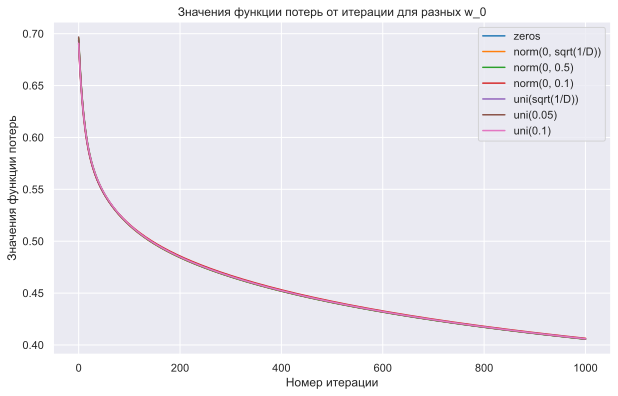

In [112]:
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(w_0)):
    sns.lineplot(x=range(0, len(all_history_w[i]['func'])), y=all_history_w[i]['func'], label=labels[i], color=colors3[i])
plt.title("Значения функции потерь от итерации для разных w_0")
plt.xlabel("Номер итерации")
plt.ylabel("Значения функции потерь")
plt.savefig('gd_w_func1.pdf')
plt.show()

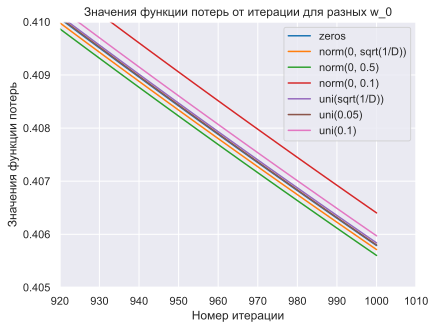

In [113]:
for i in range(0, len(w_0)):
    sns.lineplot(x=range(0, len(all_history_w[i]['func'])), y=all_history_w[i]['func'], label=labels[i], color=colors3[i])
plt.title("Значения функции потерь от итерации для разных w_0")
plt.xlabel("Номер итерации")
plt.ylabel("Значения функции потерь")
plt.ylim(0.405, 0.41) 
plt.xlim(920, 1010)
plt.savefig('gd_w_func2.pdf')
plt.show()

# Стохастический градиентный спуск для логистической регрессии

## Подбор step_alpha

In [50]:
alpha = np.arange(0, 1.5, 0.2)
alpha = np.append(alpha, [2, 5, 10, 20, 50, 70, 90])
all_history_sgd = []
for i in range(len(alpha)):
    gdc = SGDClassifier(batch_size=250, step_alpha=alpha[i])
    all_history_sgd.append(gdc.fit(X_train, y_train, w_0 = np.zeros(X_train.shape[1]), trace=True, X_test=X_test, y_test=y_test))

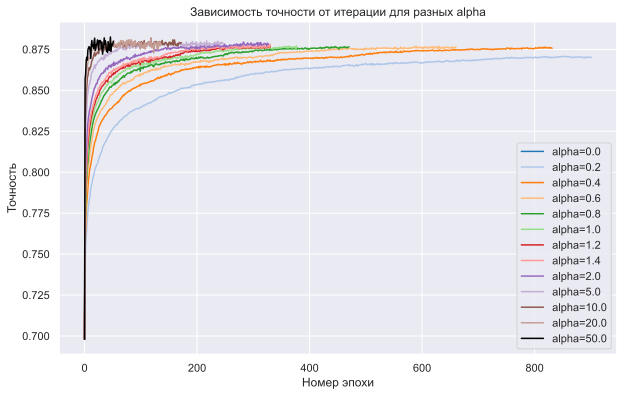

In [81]:
colors1 = sns.color_palette("tab20", len(alpha))
colors1[len(alpha)-3] = 'black'
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(alpha)-2):
    sns.lineplot(x=range(0, len(all_history_sgd[i]['accuracy'])), y=all_history_sgd[i]['accuracy'], label=('alpha=' + "%.1f" % alpha[i]), color=colors1[i])
plt.title("Зависимость точности от итерации для разных alpha")
plt.xlabel("Номер эпохи")
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel("Точность")
plt.savefig('sgd_alpha_acc1.pdf', bbox_inches="tight")
plt.show()

In [82]:
for i in range(0, len(alpha)):
    print(alpha[i], ' ', all_history_sgd[i]['accuracy'][-1])

0.0   0.6980557167730702
0.2   0.870042561423873
0.4   0.875701296188818
0.6000000000000001   0.8765718707680402
0.8   0.8765718707680402
1.0   0.8771038885664538
1.2000000000000002   0.8769587928032502
1.4000000000000001   0.878167924163281
2.0   0.8780711936544786
5.0   0.878748307216096
10.0   0.8791352292513058
20.0   0.87773263687367
50.0   0.879957438576127
70.0   0.87734571483846
90.0   0.8704778487134842


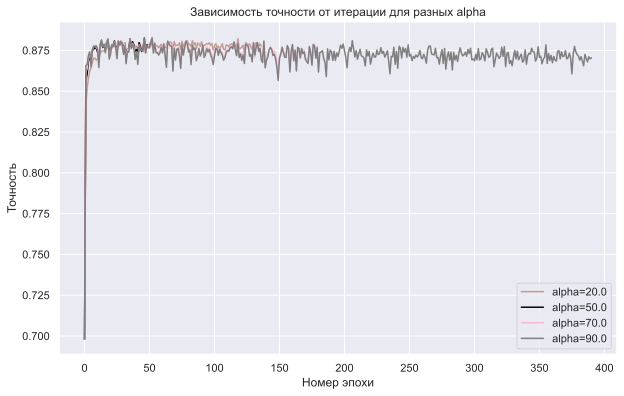

In [83]:
fig = plt.figure(figsize=(10, 6))
for i in range(len(alpha)-4, len(alpha)):
    sns.lineplot(x=range(0, len(all_history_sgd[i]['accuracy'])), y=all_history_sgd[i]['accuracy'], label=('alpha=' + "%.1f" % alpha[i]), color=colors1[i])
plt.title("Зависимость точности от итерации для разных alpha")
plt.xlabel("Номер эпохи")
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel("Точность")
plt.savefig('sgd_alpha_acc2.pdf', bbox_inches="tight")
plt.show()

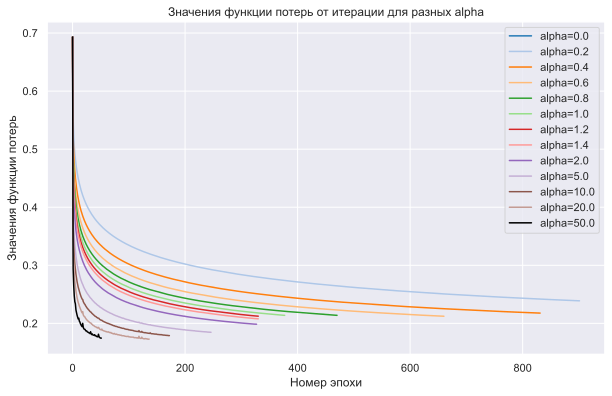

In [84]:
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(alpha)-2):
    sns.lineplot(x=range(0, len(all_history_sgd[i]['func'])), y=all_history_sgd[i]['func'], label=('alpha=' + "%.1f" % alpha[i]), color=colors1[i])
plt.title("Значения функции потерь от итерации для разных alpha")
plt.xlabel("Номер эпохи")
plt.ylabel("Значения функции потерь")
plt.savefig('sgd_alpha_func1.pdf')
plt.show()

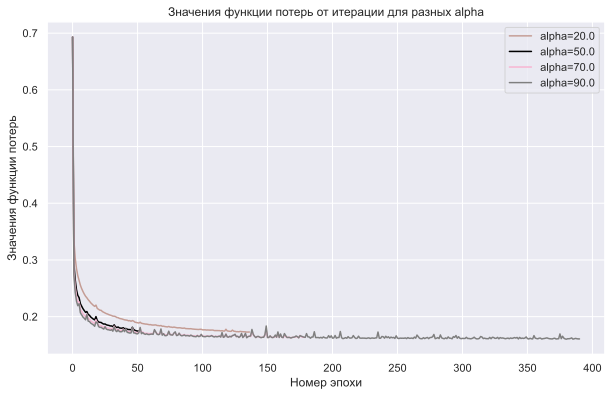

In [85]:
fig = plt.figure(figsize=(10, 6))
for i in range(len(alpha)-4, len(alpha)):
    sns.lineplot(x=range(0, len(all_history_sgd[i]['func'])), y=all_history_sgd[i]['func'], label=('alpha=' + "%.1f" % alpha[i]), color=colors1[i])
plt.title("Значения функции потерь от итерации для разных alpha")
plt.xlabel("Номер эпохи")
plt.ylabel("Значения функции потерь")
plt.savefig('sgd_alpha_func2.pdf')
plt.show()

## Подбор step_beta

In [76]:
beta = np.arange(0, 1.5, 0.1)
beta = np.append(beta, [3, 5, 10])
all_history2_sgd = []
for i in range(len(beta)):
    gdc = SGDClassifier(batch_size=250, step_beta=beta[i])
    all_history2_sgd.append(gdc.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True, X_test=X_test, y_test=y_test))

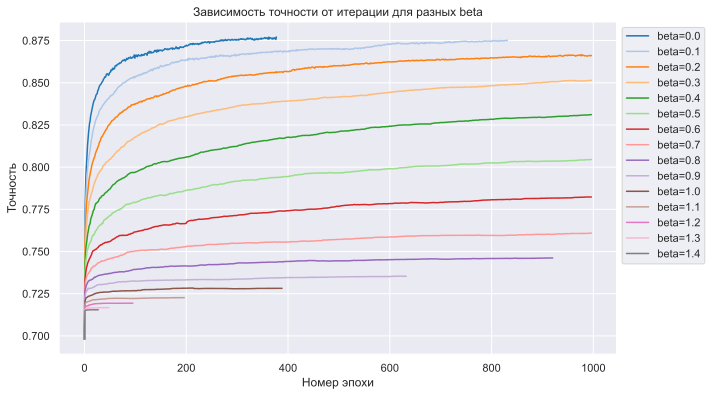

In [118]:
colors2 = sns.color_palette("tab20", len(beta))
colors2[len(beta)-3] = 'black'
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(beta)-3):
    sns.lineplot(x=range(0, len(all_history2_sgd[i]['accuracy'])), y=all_history2_sgd[i]['accuracy'], label=('beta=' + "%.1f" % beta[i]), color=colors2[i])
plt.title("Зависимость точности от итерации для разных beta")
plt.xlabel("Номер эпохи")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel("Точность")
plt.savefig('sgd_beta_acc1.pdf', bbox_inches="tight")
plt.show()

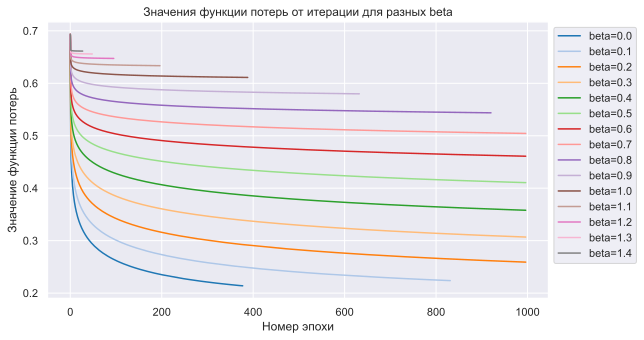

In [119]:
fig = plt.figure(figsize=(9, 5))
for i in range(0, len(beta)-3):
    sns.lineplot(x=range(0, len(all_history2_sgd[i]['func'])), y=all_history2_sgd[i]['func'], label=('beta=' + "%.1f" % beta[i]), color=colors2[i])
plt.title("Значения функции потерь от итерации для разных beta")
plt.xlabel("Номер эпохи")
plt.ylabel("Значение функции потерь")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('sgd_beta_func1.pdf', bbox_inches="tight")
plt.show()

## Подбор начального приближения

In [93]:
all_history_w_sgd = []
for i in range(len(w_0)):
    gdc = SGDClassifier(batch_size=250)
    all_history_w_sgd.append(gdc.fit(X_train, y_train, w_0=w_0[i], trace=True, X_test=X_test, y_test=y_test))

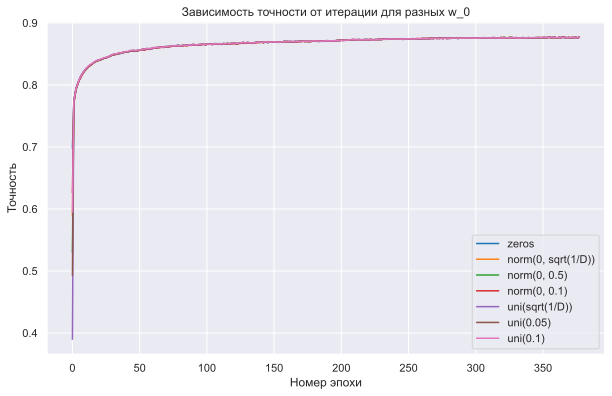

In [120]:
colors3 = sns.color_palette("tab10", len(w_0))
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(w_0)):
    sns.lineplot(x=range(0, len(all_history_w_sgd[i]['accuracy'])), y=all_history_w_sgd[i]['accuracy'], label=labels[i], color=colors3[i])
plt.title("Зависимость точности от итерации для разных w_0")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig('sgd_w_acc1.pdf')
plt.show()

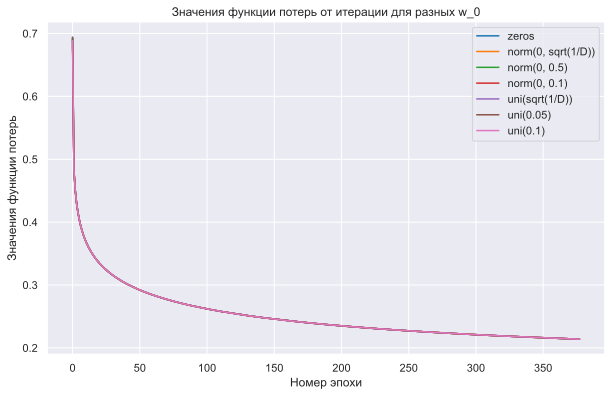

In [121]:
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(w_0)):
    sns.lineplot(x=range(0, len(all_history_w_sgd[i]['func'])), y=all_history_w_sgd[i]['func'], label=labels[i], color=colors3[i])
plt.title("Значения функции потерь от итерации для разных w_0")
plt.xlabel("Номер эпохи")
plt.ylabel("Значения функции потерь")
plt.savefig('sgd_w_func1.pdf')
plt.show()

## Подбор размера batch_size

In [263]:
sizes = [5, 25, 50, 100, 250, 500, 1000, 1500, 3000]
all_history_batch = []
for i in range(len(sizes)):
    gdc = SGDClassifier(batch_size=sizes[i])
    all_history_batch.append(gdc.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True, X_test=X_test, y_test=y_test))

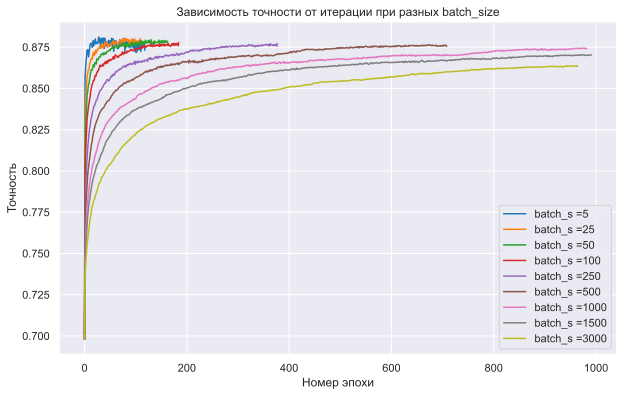

In [264]:
colors4 = sns.color_palette("tab10", len(sizes))
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(sizes)):
    sns.lineplot(x=range(0, len(all_history_batch[i]['accuracy'])), y=all_history_batch[i]['accuracy'], label='batch_s =' + str(sizes[i]), color=colors4[i])
plt.title("Зависимость точности от итерации при разных batch_size")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig('sgd_bs_acc.pdf')
plt.show()

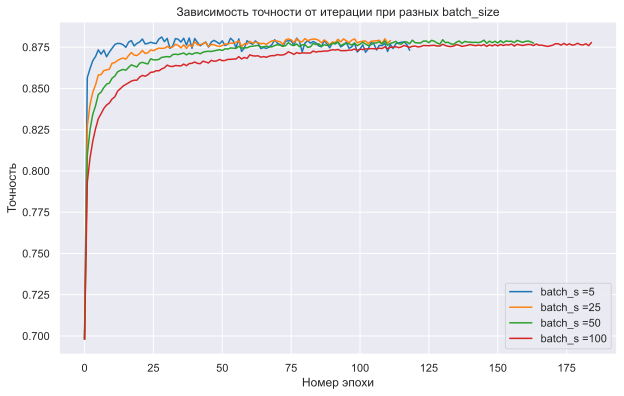

In [265]:
colors4 = sns.color_palette("tab10", len(sizes))
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(sizes)-5):
    sns.lineplot(x=range(0, len(all_history_batch[i]['accuracy'])), y=all_history_batch[i]['accuracy'], label='batch_s =' + str(sizes[i]), color=colors4[i])
plt.title("Зависимость точности от итерации при разных batch_size")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
# plt.savefig('sgd_bs_acc11.pdf')
plt.show()

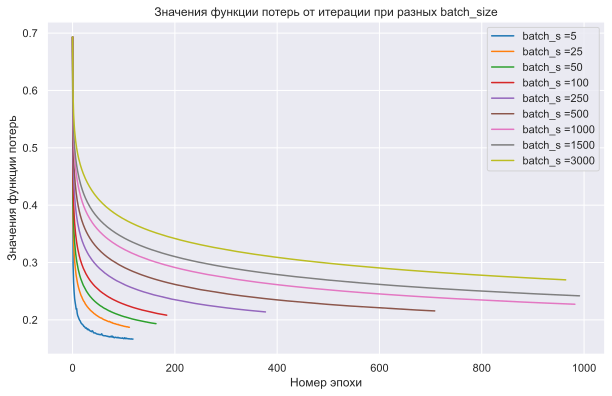

In [266]:
fig = plt.figure(figsize=(10, 6))
for i in range(0, len(sizes)):
    sns.lineplot(x=range(0, len(all_history_batch[i]['func'])), y=all_history_batch[i]['func'], label='batch_s =' + str(sizes[i]), color=colors4[i])
plt.title("Значения функции потерь от итерации при разных batch_size")
plt.xlabel("Номер эпохи")
plt.ylabel("Значения функции потерь")
# plt.savefig('sgd_bs_func.pdf')
plt.show()

# Стохастический vs обычный спуски

Наилучшие полученные храктеристики для GD:
* step_alpha = 90
* step_beta = 0
* w_0 = zeros


Наилучшие полученные характеристики для SGD:
* step_alpha = 5
* step_beta = 0
* w_0 = zeros
* batch_size = 25

In [539]:
now_time = time.time()
gd = GDClassifier(step_alpha=90, step_beta=0)
gd_history1 = gd.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True, X_test=X_test, y_test=y_test)
time.time() - now_time

15.341873407363892

In [540]:
now_time = time.time()
sgd = SGDClassifier(batch_size=100, step_alpha=10, step_beta=0)
sgd_history1 = sgd.fit(X_train, y_train, w_0=np.zeros(X_train.shape[1]), trace=True, X_test=X_test, y_test=y_test)
time.time() - now_time

9.622316837310791

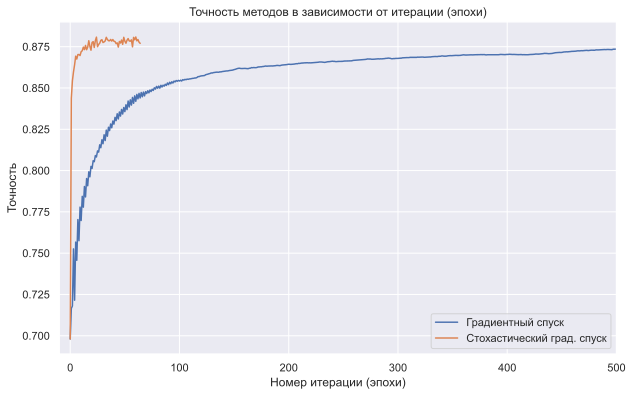

In [520]:
fig = plt.figure(figsize=(10, 6))
sns.lineplot(x=range(0, len(gd_history['accuracy'])), y=gd_history['accuracy'], label='Градиентный спуск')
sns.lineplot(x=range(0, len(sgd_history['accuracy'])), y=sgd_history['accuracy'], label='Стохастический град. спуск')
plt.title("Точность методов в зависимости от итерации (эпохи)")
plt.xlabel("Номер итерации (эпохи)")
plt.ylabel("Точность")
plt.savefig('sgdvsgd_acc.pdf')
plt.xlim(-10, 500)
plt.show()

In [293]:
sgd_history['accuracy'][-1]

0.8760882182240278

In [294]:
sgd_history['accuracy'][-1]

0.8760882182240278

In [174]:
gd_history['accuracy'][-1]

0.8764751402592378

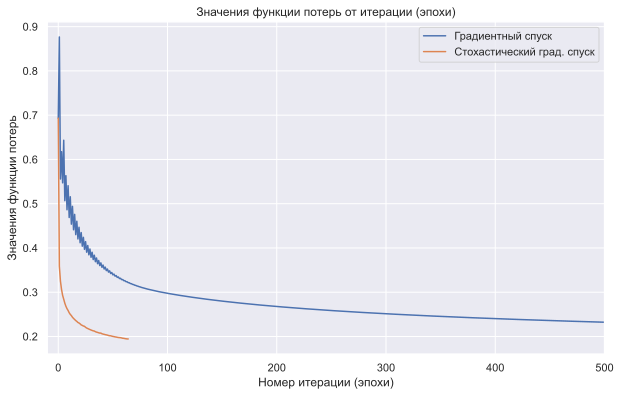

In [295]:
fig = plt.figure(figsize=(10, 6))
sns.lineplot(x=range(0, len(gd_history['func'])), y=gd_history['func'], label='Градиентный спуск')
sns.lineplot(x=range(0, len(sgd_history['func'])), y=sgd_history['func'], label='Стохастический град. спуск')
plt.title("Значения функции потерь от итерации (эпохи)")
plt.xlabel("Номер итерации (эпохи)")
plt.ylabel("Значения функции потерь")
plt.savefig('sgdvsgd_func.pdf')
plt.xlim(-10, 500)
plt.show()

50 - 16.775734424591064
100 - 9.400623798370361

In [522]:
temp = 0
times_gd = []
times_sgd = []
for i in range(len(gd_history['time'])):
    temp += gd_history['time'][i]
    times_gd.append(temp)
temp = 0
for i in range(len(sgd_history['time'])):
    temp += sgd_history['time'][i]
    times_sgd.append(temp)

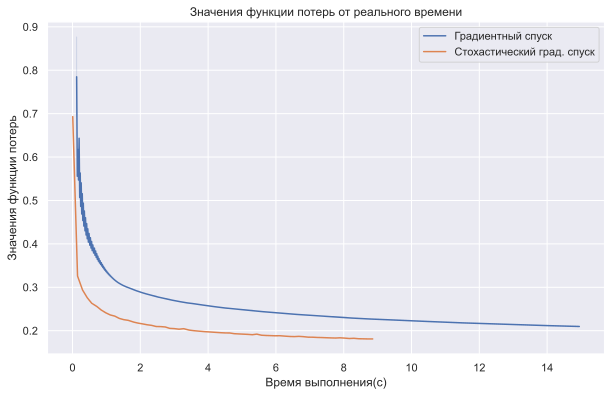

In [523]:
fig = plt.figure(figsize=(10, 6))
sns.lineplot(x=times_gd, y=gd_history['func'], label='Градиентный спуск')
sns.lineplot(x=times_sgd, y=sgd_history['func'], label='Стохастический град. спуск')
plt.title("Значения функции потерь от реального времени")
plt.xlabel("Время выполнения(с)")
plt.ylabel("Значения функции потерь")
plt.savefig('sgdvsgd_func_time.pdf')
plt.show()

# Лематизация

In [185]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab') 

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dan-z\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dan-z\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dan-z\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dan-z\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [192]:
train_comment_lem = train_comment.apply(preprocess_text)
test_comment_lem = test_comment.apply(preprocess_text)

In [204]:
vectorizer = CountVectorizer(min_df=0.001) 
X_train_lem = vectorizer.fit_transform(train_comment_lem)
vectorizer.fit(train_comment_lem)
X_test_lem = vectorizer.transform(test_comment_lem)
X_train_lem = normalize(X_train_lem, norm='l2', axis=1)
X_test_lem = normalize(X_test_lem, norm='l2', axis=1)


In [205]:
X_train.shape

(52061, 3736)

In [206]:
X_train_lem.shape

(52061, 3399)

In [196]:
train_comment

0        explanation why the edits made under my userna...
1        d aww  he matches this background colour i m s...
2        hey man  i m really not trying to edit war  it...
3          more i can t make any real suggestions on im...
4        you  sir  are my hero  any chance you remember...
                               ...                        
52056        our previous conversation   you fucking sh...
52057                    you are a mischievious pubic hair
52058    your absurd edits   your absurd edits on great...
52059       hey listen don t you ever     delete my edi...
52060    and i m going to keep posting the stuff u dele...
Name: comment_text, Length: 52061, dtype: object

In [197]:
train_comment_lem

0        explanation edits made username hardcore metal...
1        aww match background colour seemingly stuck th...
2        hey man really trying edit war guy constantly ...
3        make real suggestion improvement wondered sect...
4                            sir hero chance remember page
                               ...                        
52056    previous conversation fucking shit eating libe...
52057                              mischievious pubic hair
52058    absurd edits absurd edits great white shark wa...
52059    hey listen ever delete edits ever annoyed wwe ...
52060    going keep posting stuff u deleted fucking sit...
Name: comment_text, Length: 52061, dtype: object

In [541]:
now_time = time.time()
gd = GDClassifier(step_alpha=90, step_beta=0)
gd_history = gd.fit(X_train_lem, y_train, w_0=np.zeros(X_train_lem.shape[1]), trace=True, X_test=X_test_lem, y_test=y_test)
time.time() - now_time 

12.004254341125488

In [542]:
now_time = time.time()
sgd = SGDClassifier(batch_size=100, step_alpha=10, step_beta=0)
sgd_history = sgd.fit(X_train_lem, y_train, w_0=np.zeros(X_train_lem.shape[1]), trace=True, X_test=X_test_lem, y_test=y_test)
time.time() - now_time

9.565207242965698

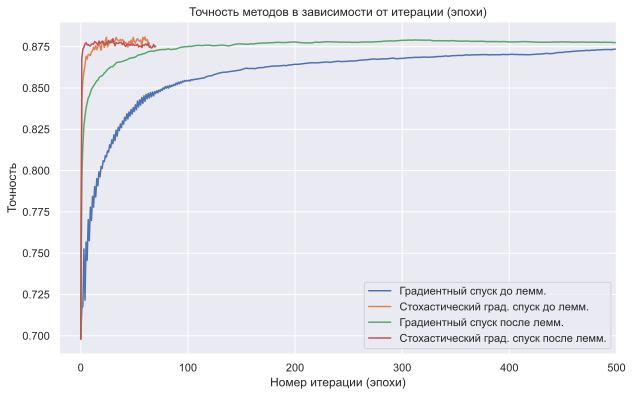

In [543]:
fig = plt.figure(figsize=(10, 6))
sns.lineplot(x=range(0, len(gd_history1['accuracy'])), y=gd_history1['accuracy'], label='Градиентный спуск до лемм.')
sns.lineplot(x=range(0, len(sgd_history1['accuracy'])), y=sgd_history1['accuracy'], label='Стохастический град. спуск до лемм.')
sns.lineplot(x=range(0, len(gd_history['accuracy'])), y=gd_history['accuracy'], label='Градиентный спуск после лемм.')
sns.lineplot(x=range(0, len(sgd_history['accuracy'])), y=sgd_history['accuracy'], label='Стохастический град. спуск после лемм.')
plt.title("Точность методов в зависимости от итерации (эпохи)")
plt.xlabel("Номер итерации (эпохи)")
plt.ylabel("Точность")
plt.savefig('sgdvsgd_acc_lem.pdf')
plt.xlim(-20, 500)
plt.show()

In [531]:
sgd_history['accuracy'][-1]

0.875314374153608

In [532]:
gd_history['accuracy'][-1]

0.878361385180886

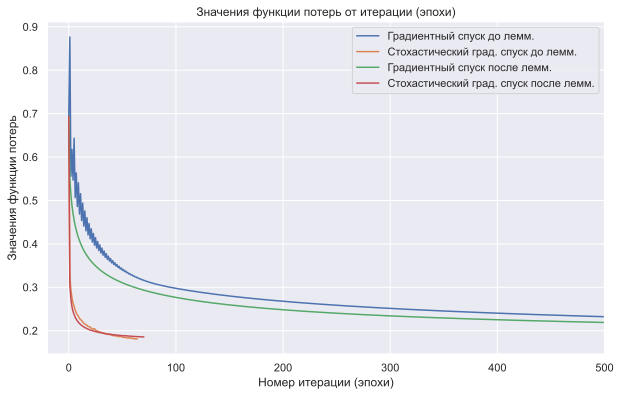

In [544]:
fig = plt.figure(figsize=(10, 6))
sns.lineplot(x=range(0, len(gd_history1['func'])), y=gd_history1['func'], label='Градиентный спуск до лемм.')
sns.lineplot(x=range(0, len(sgd_history1['func'])), y=sgd_history1['func'], label='Стохастический град. спуск до лемм.')
sns.lineplot(x=range(0, len(gd_history['func'])), y=gd_history['func'], label='Градиентный спуск после лемм.')
sns.lineplot(x=range(0, len(sgd_history['func'])), y=sgd_history['func'], label='Стохастический град. спуск после лемм.')
plt.title("Значения функции потерь от итерации (эпохи)")
plt.xlabel("Номер итерации (эпохи)")
plt.ylabel("Значения функции потерь")
plt.savefig('sgdvsgd_func_lem2.pdf')
plt.xlim(-20, 500)
plt.show()

# Сравнение BagOfWords и Tfid

In [357]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


bow_vectorizer = CountVectorizer(min_df=0.001, max_df=0.9)
X_train_bow = bow_vectorizer.fit_transform(train_comment_lem)
bow_vectorizer.fit(train_comment_lem)
X_test_bow = bow_vectorizer.transform(test_comment_lem)
X_train_bow = normalize(X_train_bow, norm='l2', axis=1)
X_test_bow = normalize(X_test_bow, norm='l2', axis=1)

In [268]:
tfidf = TfidfVectorizer(min_df=0.1, max_df=max_df)
X_train_tfidf = tfidf.fit_transform(train_comment_lem)
tfidf.fit(train_comment_lem)
X_test_tfidf = tfidf.transform(test_comment_lem)

In [358]:
min_df = [10**(-6), 10**(-4), 10**(-3), 10**(-2), 10**(-1)]
max_df = [0.3, 0.5, 0.7, 0.8, 0.9]

## Подбор коэффициента регуляризации

In [389]:
l2_coefs = [0.0005, 0.001, 0.01, 0.1, 0.5, 1]
for i in l2_coefs:
    sgd = SGDClassifier(batch_size=100, step_alpha=10, step_beta=0, l2_coef=i)
    a = (sgd.fit(X_train_bow, y_train, w_0=np.zeros(X_train_bow.shape[1]), trace=True, X_test=X_test_bow, y_test=y_test))
    print(i, ' ', a['accuracy'][-1])
    
    gd = GDClassifier(step_alpha=90, step_beta=0, l2_coef=i)
    b = gd.fit(X_train_bow, y_train, w_0=np.zeros(X_train_bow.shape[1]), trace=True, X_test=X_test_bow, y_test=y_test)
    print(i, ' ', b['accuracy'][-1])
    print()
    

0.0005   0.853985296962662
0.0005   0.8563068291739214

0.001   0.848906945250532
0.001   0.8484716579609208

0.01   0.8114722383439736
0.01   0.8177597214161346

0.1   0.7659605339524086
0.1   0.6980557167730702



KeyboardInterrupt: 

## BagOfWords

sgd

In [447]:
bow_times_min_gd = []
bow_times_min_sgd = []
bow_acc_min_sgd = []
bow_acc_min_gd = []
shapes_bow_min = []
for i in range(len(min_df)):
    bow_vectorizer = CountVectorizer(min_df=min_df[i])
    X_train_bow = bow_vectorizer.fit_transform(train_comment_lem)
    bow_vectorizer.fit(train_comment_lem)
    shapes_bow_min.append(X_train_bow.shape[1])
    X_test_bow = bow_vectorizer.transform(test_comment_lem)
    X_train_bow = normalize(X_train_bow, norm='l2', axis=1)
    X_test_bow = normalize(X_test_bow, norm='l2', axis=1)
    
    
    sgd = SGDClassifier(batch_size=1000, step_alpha=10, step_beta=0, l2_coef=0.0005)
    all_history_bow_min_sgd = sgd.fit(X_train_bow, y_train, w_0=np.zeros(X_train_bow.shape[1]), trace=True, X_test=X_test_bow, y_test=y_test)
    bow_acc_min_sgd.append(all_history_bow_min_sgd['accuracy'][-1])
    bow_times_min_sgd.append(np.sum(all_history_bow_min_sgd['time']))
    
    gd = GDClassifier(step_alpha=90, step_beta=0, l2_coef=0.0005)
    all_history_bow_min_gd = gd.fit(X_train_bow, y_train, w_0=np.zeros(X_train_bow.shape[1]), trace=True, X_test=X_test_bow, y_test=y_test)
    bow_acc_min_gd.append(all_history_bow_min_gd['accuracy'][-1])
    bow_times_min_gd.append(np.sum(all_history_bow_min_gd['time']))

In [448]:
bow_times_max_gd = []
bow_times_max_sgd = []
bow_acc_max_sgd = []
bow_acc_max_gd = []
shapes_bow_max = []
for i in range(len(max_df)):
    bow_vectorizer = CountVectorizer(max_df=max_df[i])
    X_train_bow = bow_vectorizer.fit_transform(train_comment_lem)
    bow_vectorizer.fit(train_comment_lem)
    shapes_bow_max.append(X_train_bow.shape[1])
    X_test_bow = bow_vectorizer.transform(test_comment_lem)
    X_train_bow = normalize(X_train_bow, norm='l2', axis=1)
    X_test_bow = normalize(X_test_bow, norm='l2', axis=1)
    
    sgd = SGDClassifier(batch_size=1000, step_alpha=10, step_beta=0, l2_coef=0.0005)
    all_history_bow_min_sgd = sgd.fit(X_train_bow, y_train, w_0=np.zeros(X_train_bow.shape[1]), trace=True, X_test=X_test_bow, y_test=y_test)
    bow_acc_max_sgd.append(all_history_bow_min_sgd['accuracy'][-1])
    bow_times_max_sgd.append(np.sum(all_history_bow_min_sgd['time']))
    
    gd = GDClassifier(step_alpha=90, step_beta=0, l2_coef=0.0005)
    all_history_bow_min_gd = gd.fit(X_train_bow, y_train, w_0=np.zeros(X_train_bow.shape[1]), trace=True, X_test=X_test_bow, y_test=y_test)
    bow_acc_max_gd.append(all_history_bow_min_gd['accuracy'][-1])
    bow_times_max_gd.append(np.sum(all_history_bow_min_gd['time']))

In [427]:
all_history_bow_max_gd[1]['accuracy'][-1]

0.8484716579609208

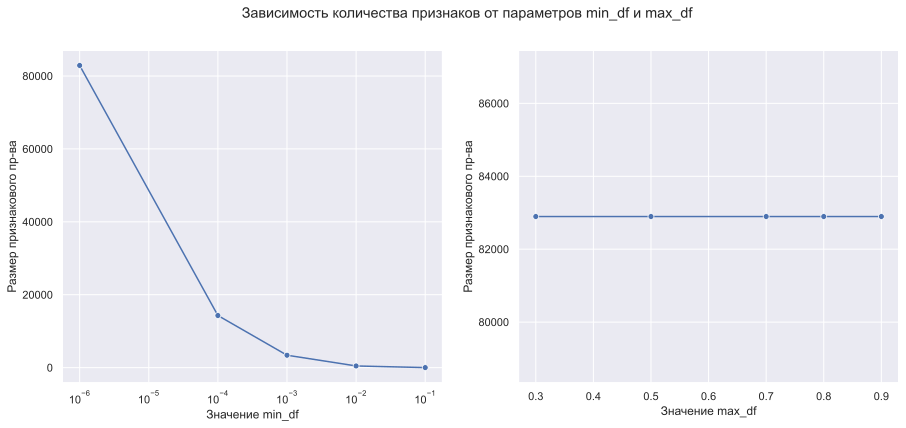

In [428]:
fig = plt.figure(figsize=(15, 6))
plt.suptitle('Зависимость количества признаков от параметров min_df и max_df')
plt.subplot(1, 2, 1)
sns.lineplot(x=min_df, y=shapes_bow_min, marker='o')
plt.xlabel("Значение min_df")
plt.ylabel("Размер признакового пр-ва")
plt.xscale('log')

plt.subplot(1, 2, 2)
sns.lineplot(x=max_df, y=shapes_bow_max, marker='o')
plt.xlabel("Значение max_df")
plt.ylabel("Размер признакового пр-ва")

plt.savefig('bow_features.pdf')
plt.show()

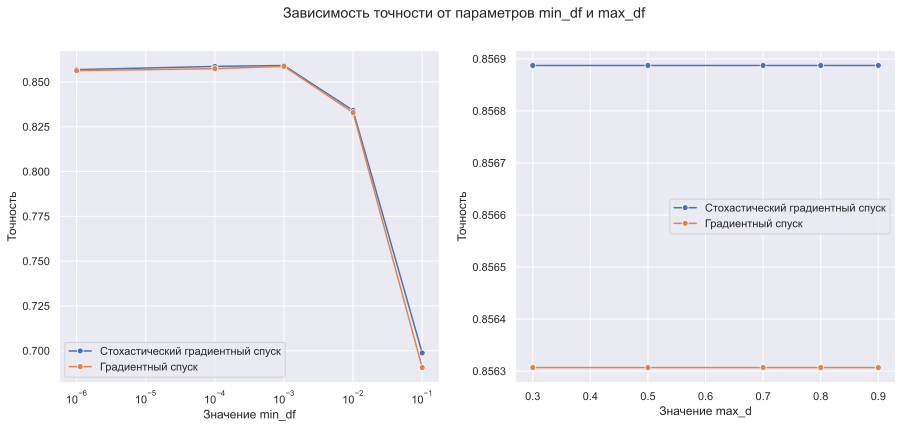

In [442]:
fig = plt.figure(figsize=(15, 6))
plt.suptitle('Зависимость точности от параметров min_df и max_df')
plt.subplot(1, 2, 1)
sns.lineplot(x=min_df, y=bow_acc_min_sgd, marker='o', label='Стохастический градиентный спуск')
sns.lineplot(x=min_df, y=bow_acc_min_gd, marker='o', label='Градиентный спуск')
plt.xlabel("Значение min_df")
plt.ylabel("Точность")
plt.xscale('log')

plt.subplot(1, 2, 2)
sns.lineplot(x=max_df, y=bow_acc_max_sgd, marker='o', label='Стохастический градиентный спуск')
sns.lineplot(x=max_df, y=bow_acc_max_gd, marker='o', label='Градиентный спуск')
plt.xlabel("Значение max_d")
plt.ylabel("Точность")

plt.savefig('bow_acc.pdf')
plt.show()

In [430]:
bow_times_min_gd

[0.7927756309509277,
 0.7125952243804932,
 0.5908703804016113,
 0.5536162853240967,
 9.574927806854248]

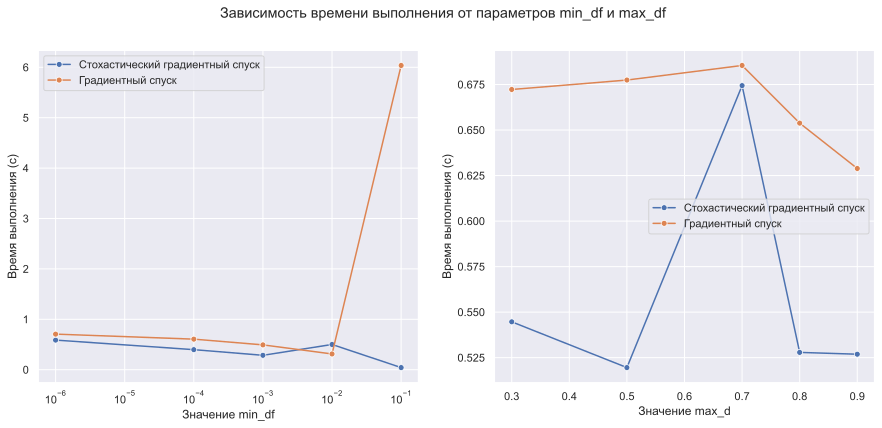

In [449]:
fig = plt.figure(figsize=(15, 6))
plt.suptitle('Зависимость времени выполнения от параметров min_df и max_df')
plt.subplot(1, 2, 1)
sns.lineplot(x=min_df, y=bow_times_min_sgd, marker='o', label='Стохастический градиентный спуск')
sns.lineplot(x=min_df, y=bow_times_min_gd, marker='o', label='Градиентный спуск')
plt.xlabel("Значение min_df")
plt.ylabel("Время выполнения (с)")
plt.xscale('log')

plt.subplot(1, 2, 2)
sns.lineplot(x=max_df, y=bow_times_max_sgd, marker='o', label='Стохастический градиентный спуск')
sns.lineplot(x=max_df, y=bow_times_max_gd, marker='o', label='Градиентный спуск')
plt.xlabel("Значение max_d")
plt.ylabel("Время выполнения (с)")

plt.savefig('bow_time.pdf')
plt.show()

## Tfid

### Новый подбор коэффициента регуляризации

In [432]:
tfidf = TfidfVectorizer(min_df=0.001, max_df=0.9)
X_train_tfidf = tfidf.fit_transform(train_comment_lem)
tfidf.fit(train_comment_lem)
X_test_tfidf = tfidf.transform(test_comment_lem)
X_train_tfidf = normalize(X_train_tfidf, norm='l2', axis=1)
X_test_tfidf = normalize(X_test_tfidf, norm='l2', axis=1)

In [388]:
l2_coefs = [0.005, 0.001, 0.01, 0.1, 0.5, 1]
for i in l2_coefs:
    sgd = SGDClassifier(batch_size=100, step_alpha=10, step_beta=0, l2_coef=i)
    a = (sgd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), trace=True, X_test=X_test_tfidf, y_test=y_test))
    print(i, ' ', a['accuracy'][-1])
    
    gd = GDClassifier(step_alpha=90, step_beta=0, l2_coef=i)
    b = gd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), trace=True, X_test=X_test_tfidf, y_test=y_test)
    print(i, ' ', b['accuracy'][-1])
    print()

0.005   0.839765912168698
0.005   0.838556780808667

0.001   0.8587250918939834
0.001   0.8609982588508416

0.01   0.8306732443412652
0.01   0.829609208744438

0.1   0.7980266976204294
0.1   0.6980557167730702



KeyboardInterrupt: 

### Эксперименты с Tfid

In [450]:
tfid_times_min_gd = []
tfid_times_min_sgd = []
tfid_acc_min_sgd = []
tfid_acc_min_gd = []
shapes_tfid_min = []
for i in range(len(min_df)):
    tfidf = TfidfVectorizer(min_df=min_df[i])
    X_train_tfidf = tfidf.fit_transform(train_comment_lem)
    tfidf.fit(train_comment_lem)
    X_test_tfidf = tfidf.transform(test_comment_lem)
    shapes_tfid_min.append(X_train_tfidf.shape[1])
    X_train_tfidf = normalize(X_train_tfidf, norm='l2', axis=1)
    X_test_tfidf = normalize(X_test_tfidf, norm='l2', axis=1)
    
    sgd = SGDClassifier(batch_size=1000, step_alpha=10, step_beta=0, l2_coef=0.001)
    all_history_bow_min_sgd = sgd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), trace=True, X_test=X_test_tfidf, y_test=y_test)
    tfid_acc_min_sgd.append(all_history_bow_min_sgd['accuracy'][-1])
    tfid_times_min_sgd.append(np.sum(all_history_bow_min_sgd['time']))
    
    gd = GDClassifier(step_alpha=90, step_beta=0, l2_coef=0.001)
    all_history_bow_min_gd = gd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), trace=True, X_test=X_test_tfidf, y_test=y_test)
    tfid_acc_min_gd.append(all_history_bow_min_gd['accuracy'][-1])
    tfid_times_min_gd.append(np.sum(all_history_bow_min_gd['time']))

In [451]:
tfid_times_max_gd = []
tfid_times_max_sgd = []
tfid_acc_max_sgd = []
tfid_acc_max_gd = []
shapes_tfid_max = []
for i in range(len(max_df)):
    tfidf = TfidfVectorizer(max_df=max_df[i])
    X_train_tfidf = tfidf.fit_transform(train_comment_lem)
    tfidf.fit(train_comment_lem)
    X_test_tfidf = tfidf.transform(test_comment_lem)
    shapes_tfid_max.append(X_train_tfidf.shape[1])
    X_train_tfidf = normalize(X_train_tfidf, norm='l2', axis=1)
    X_test_tfidf = normalize(X_test_tfidf, norm='l2', axis=1)
    
    sgd = SGDClassifier(batch_size=1000, step_alpha=10, step_beta=0, l2_coef=0.001)
    all_history_bow_min_sgd = sgd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), trace=True, X_test=X_test_tfidf, y_test=y_test)
    tfid_acc_max_sgd.append(all_history_bow_min_sgd['accuracy'][-1])
    tfid_times_max_sgd.append(np.sum(all_history_bow_min_sgd['time']))
    
    gd = GDClassifier(step_alpha=90, step_beta=0, l2_coef=0.001)
    all_history_bow_min_gd = gd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), trace=True, X_test=X_test_tfidf, y_test=y_test)
    tfid_acc_max_gd.append(all_history_bow_min_gd['accuracy'][-1])
    tfid_times_max_gd.append(np.sum(all_history_bow_min_gd['time']))

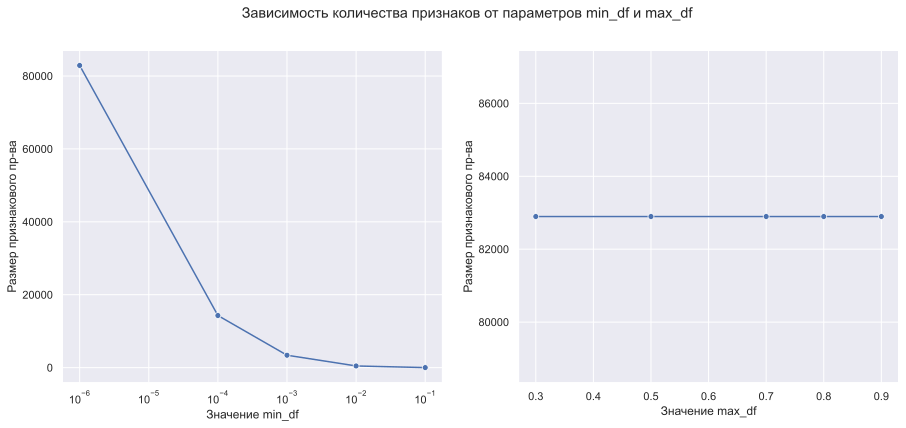

In [452]:
fig = plt.figure(figsize=(15, 6))
plt.suptitle('Зависимость количества признаков от параметров min_df и max_df')
plt.subplot(1, 2, 1)
sns.lineplot(x=min_df, y=shapes_bow_min, marker='o')
plt.xlabel("Значение min_df")
plt.ylabel("Размер признакового пр-ва")
plt.xscale('log')

plt.subplot(1, 2, 2)
sns.lineplot(x=max_df, y=shapes_bow_max, marker='o')
plt.xlabel("Значение max_df")
plt.ylabel("Размер признакового пр-ва")

plt.savefig('tfid_features.pdf')
plt.show()

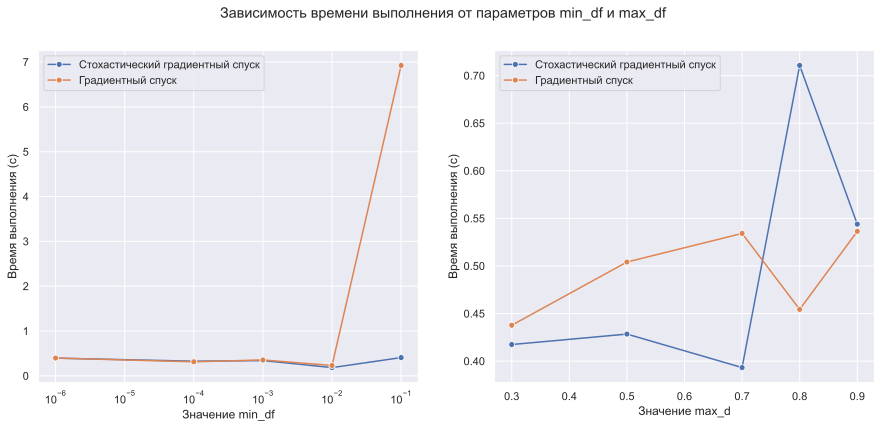

In [454]:
fig = plt.figure(figsize=(15, 6))
plt.suptitle('Зависимость времени выполнения от параметров min_df и max_df')
plt.subplot(1, 2, 1)
sns.lineplot(x=min_df, y=tfid_times_min_sgd, marker='o', label='Стохастический градиентный спуск')
sns.lineplot(x=min_df, y=tfid_times_min_gd, marker='o', label='Градиентный спуск')
plt.xlabel("Значение min_df")
plt.ylabel("Время выполнения (с)")
plt.xscale('log')

plt.subplot(1, 2, 2)
sns.lineplot(x=max_df, y=tfid_times_max_sgd, marker='o', label='Стохастический градиентный спуск')
sns.lineplot(x=max_df, y=tfid_times_max_gd, marker='o', label='Градиентный спуск')
plt.xlabel("Значение max_d")
plt.ylabel("Время выполнения (с)")

plt.savefig('tfid_time.pdf')
plt.show()

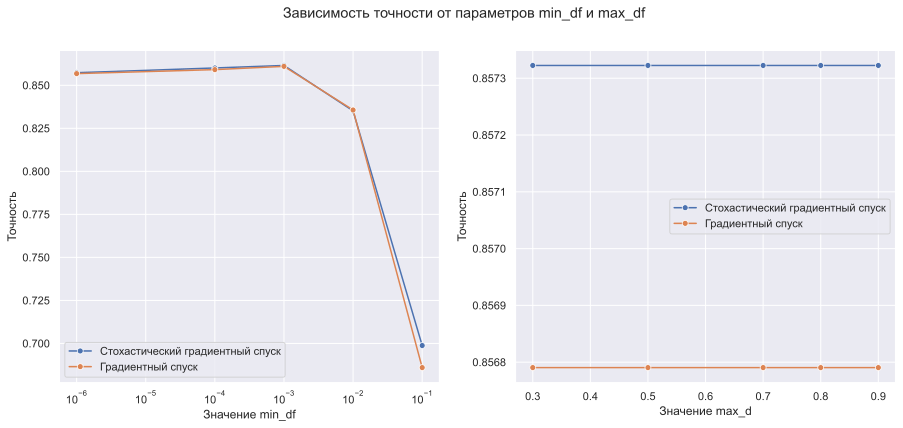

In [453]:
fig = plt.figure(figsize=(15, 6))
plt.suptitle('Зависимость точности от параметров min_df и max_df')
plt.subplot(1, 2, 1)
sns.lineplot(x=min_df, y=tfid_acc_min_sgd, marker='o', label='Стохастический градиентный спуск')
sns.lineplot(x=min_df, y=tfid_acc_min_gd, marker='o', label='Градиентный спуск')
plt.xlabel("Значение min_df")
plt.ylabel("Точность")
plt.xscale('log')

plt.subplot(1, 2, 2)
sns.lineplot(x=max_df, y=tfid_acc_max_sgd, marker='o', label='Стохастический градиентный спуск')
sns.lineplot(x=max_df, y=tfid_acc_max_gd, marker='o', label='Градиентный спуск')
plt.xlabel("Значение max_d")
plt.ylabel("Точность")

plt.savefig('tfid_acc.pdf')
plt.show()

## BOW VS TDIF

In [455]:
tfidf = TfidfVectorizer(min_df=10**(-3), max_df=0.7)
X_train_tfidf = tfidf.fit_transform(train_comment_lem)
tfidf.fit(train_comment_lem)
X_test_tfidf = tfidf.transform(test_comment_lem)
X_train_tfidf = normalize(X_train_tfidf, norm='l2', axis=1)
X_test_tfidf = normalize(X_test_tfidf, norm='l2', axis=1)

bow_vectorizer = CountVectorizer(min_df=10**(-3), max_df=0.5)
X_train_bow = bow_vectorizer.fit_transform(train_comment_lem)
bow_vectorizer.fit(train_comment_lem)
X_test_bow = bow_vectorizer.transform(test_comment_lem)
X_train_bow = normalize(X_train_bow, norm='l2', axis=1)
X_test_bow = normalize(X_test_bow, norm='l2', axis=1)

sgd = SGDClassifier(batch_size=100, step_alpha=10, step_beta=0, l2_coef=0.0005)
all_history_bow_min_sgd = sgd.fit(X_train_bow, y_train, w_0=np.zeros(X_train_bow.shape[1]), trace=True, X_test=X_test_bow, y_test=y_test)
print('sgd bow', ' ', all_history_bow_min_sgd['accuracy'][-1])

gd = GDClassifier(step_alpha=90, step_beta=0, l2_coef=0.0005)
all_history_bow_min_gd = gd.fit(X_train_bow, y_train, w_0=np.zeros(X_train_bow.shape[1]), trace=True, X_test=X_test_bow, y_test=y_test)
print('gd bow', ' ', all_history_bow_min_gd['accuracy'][-1])

sgd = SGDClassifier(batch_size=100, step_alpha=10, step_beta=0, l2_coef=0.001)
all_history_bow_min_sgd = sgd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), trace=True, X_test=X_test_tfidf, y_test=y_test)
print('sgd tfidf', ' ', all_history_bow_min_sgd['accuracy'][-1])

gd = GDClassifier(step_alpha=90, step_beta=0, l2_coef=0.001)
all_history_bow_min_gd = gd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), trace=True, X_test=X_test_tfidf, y_test=y_test)
print('gd tfidf', ' ', all_history_bow_min_gd['accuracy'][-1])

sgd bow   0.8593538402011994
gd bow   0.8587250918939834
sgd tfidf   0.8587250918939834
gd tfidf   0.8609982588508416


# Поиск лучшей модели

In [504]:
from sklearn.metrics import accuracy_score

alphas = [5, 10, 50, 90]
beta = [0, 0.1, 0.5, 0.7]
l2_coefs = [0.001, 0.0005, 0.01]

tfidf = TfidfVectorizer(min_df=10**(-3), max_df=0.7)
X_train_tfidf = tfidf.fit_transform(train_comment_lem)
tfidf.fit(train_comment_lem)
X_test_tfidf = tfidf.transform(test_comment_lem)
X_train_tfidf = normalize(X_train_tfidf, norm='l2', axis=1)
X_test_tfidf = normalize(X_test_tfidf, norm='l2', axis=1)

bow_vectorizer = CountVectorizer(min_df=10**(-3), max_df=0.5)
X_train_bow = bow_vectorizer.fit_transform(train_comment_lem)
bow_vectorizer.fit(train_comment_lem)
X_test_bow = bow_vectorizer.transform(test_comment_lem)
X_train_bow = normalize(X_train_bow, norm='l2', axis=1)
X_test_bow = normalize(X_test_bow, norm='l2', axis=1)

for a in alphas:
    for b in beta:
        for l2 in l2_coefs:
            sgd = SGDClassifier(batch_size=500, step_alpha=a, step_beta=b, l2_coef=l2)
            all_history =sgd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), X_test=X_test_tfidf, y_test=y_test)
            print(a, b, l2, 'tfidf', ' ', "%.6f" % (accuracy_score(y_test, sgd.predict(X_test_tfidf))))
            sgd.fit(X_train_bow, y_train, w_0=np.zeros(X_train_bow.shape[1]), X_test=X_test_bow, y_test=y_test)
            print(a, b, l2, 'bow', ' ', "%.6f" % accuracy_score(y_test, sgd.predict(X_test_bow)))


5 0 0.001 tfidf   0.861288
5 0 0.001 bow   0.851809
5 0 0.0005 tfidf   0.868156
5 0 0.0005 bow   0.858387
5 0 0.01 tfidf   0.827820
5 0 0.01 bow   0.818630
5 0.1 0.001 tfidf   0.861095
5 0.1 0.001 bow   0.851277
5 0.1 0.0005 tfidf   0.868833
5 0.1 0.0005 bow   0.858338
5 0.1 0.01 tfidf   0.829754
5 0.1 0.01 bow   0.819743
5 0.5 0.001 tfidf   0.858145
5 0.5 0.001 bow   0.847746
5 0.5 0.0005 tfidf   0.864190
5 0.5 0.0005 bow   0.854421
5 0.5 0.01 tfidf   0.828690
5 0.5 0.01 bow   0.818727
5 0.7 0.001 tfidf   0.845521
5 0.7 0.001 bow   0.836864
5 0.7 0.0005 tfidf   0.847021
5 0.7 0.0005 bow   0.839282
5 0.7 0.01 tfidf   0.825305
5 0.7 0.01 bow   0.815341
10 0 0.001 tfidf   0.861095
10 0 0.001 bow   0.852341
10 0 0.0005 tfidf   0.869027
10 0 0.0005 bow   0.859209
10 0 0.01 tfidf   0.829126
10 0 0.01 bow   0.820758
10 0.1 0.001 tfidf   0.861385
10 0.1 0.001 bow   0.851809
10 0.1 0.0005 tfidf   0.869317
10 0.1 0.0005 bow   0.858677
10 0.1 0.01 tfidf   0.830722
10 0.1 0.01 bow   0.818485
10 0

# Анализ ошибок

In [464]:
def get_prediction_errors(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = np.where(predictions != y_test)[0]  # Индексы ошибок
    return errors, predictions

Лучшая модель - 10	0.1	0.0005	tfidf	0.869317

In [499]:
sgd = SGDClassifier(batch_size=500, step_alpha=10, step_beta=0.1, l2_coef=0.0005)
sgd.fit(X_train_tfidf, y_train, w_0=np.zeros(X_train_tfidf.shape[1]), X_test=X_test_tfidf, y_test=y_test)
err, predict =  get_prediction_errors(sgd, X_test_tfidf, y_test)
test_comment_lem[err], predict


(1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [468]:
error_data = {
    "Комментарий": test_comment_lem[err],
    "Предсказание": predict[err],
    "Истинный класс": y_test[err]
}
pd.set_option('display.max_colwidth', None)
error_table = pd.DataFrame(error_data)
error_table

Комментарий  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     dear god site horrible   
8                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     arab committing genocide iraq protest europe may europe also burn hell   
12                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       jew race get mother mention ethiopian jew testing jew prof well fact accept convert   
38                                                                                               

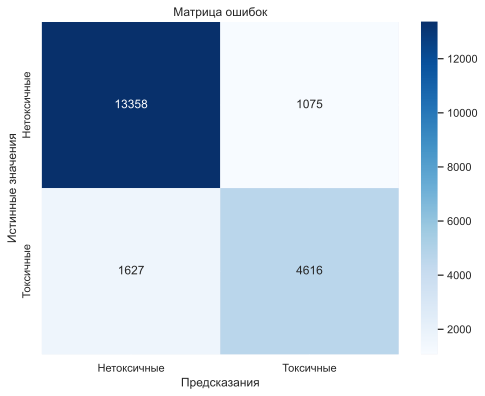

In [469]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Получаем предсказания модели
predictions = sgd.predict(X_test_tfidf)  # Используем подходящее представление данных (например, tf-idf)

# Строим матрицу ошибок
cm = confusion_matrix(y_test, predictions)

# Визуализируем матрицу ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Нетоксичные', 'Токсичные'], yticklabels=['Нетоксичные', 'Токсичные'])
plt.xlabel('Предсказания')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()


In [480]:
false_positives = np.where((predictions == 1) & (y_test == -1))[0]
false_negatives = np.where((predictions == -1) & (y_test == 1))[0]
false_positive_comments = test_comment_lem[false_positives]
false_negative_comments = test_comment_lem[false_negatives]
vectorizer1 = CountVectorizer(min_df=1)
vectorizer1.fit(test_comment_lem)
false_positive_words = vectorizer1.transform(false_positive_comments)
false_negative_words = vectorizer1.transform(false_negative_comments)
from collections import Counter

# Получаем список слов из векторизованных комментариев
false_positive_words_list = vectorizer.inverse_transform(false_positive_words)
false_negative_words_list = vectorizer.inverse_transform(false_negative_words)

# Создаем список слов из всех комментариев с ошибками
all_false_positive_words = [word for sublist in false_positive_words_list for word in sublist]
all_false_negative_words = [word for sublist in false_negative_words_list for word in sublist]

# Подсчитываем количество каждого слова
fp_word_counts = Counter(all_false_positive_words)
fn_word_counts = Counter(all_false_negative_words)

# Выводим самые частые слова для каждой категории ошибок
print("Часто встречающиеся слова в ложных положительных предсказаниях:")
print(fp_word_counts.most_common(20))

print("Часто встречающиеся слова в ложных отрицательных предсказаниях:")
print(fn_word_counts.most_common(20))


Часто встречающиеся слова в ложных положительных предсказаниях:
[('like', 121), ('get', 99), ('people', 90), ('go', 70), ('wikipedia', 55), ('stop', 54), ('know', 52), ('say', 48), ('life', 48), ('going', 41), ('stupid', 40), ('fucking', 40), ('time', 40), ('hate', 38), ('think', 38), ('one', 37), ('oh', 37), ('ha', 36), ('suck', 35), ('make', 35)]
Часто встречающиеся слова в ложных отрицательных предсказаниях:
[('wa', 337), ('article', 266), ('page', 219), ('like', 218), ('one', 198), ('ha', 186), ('know', 163), ('wikipedia', 159), ('think', 158), ('would', 157), ('stupid', 148), ('please', 145), ('people', 139), ('also', 130), ('see', 125), ('say', 124), ('time', 119), ('get', 115), ('make', 109), ('even', 105)]


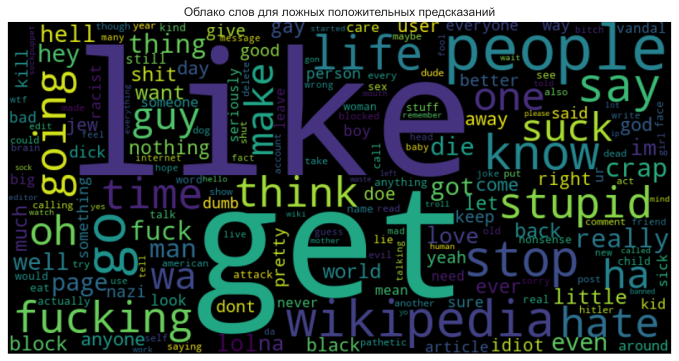

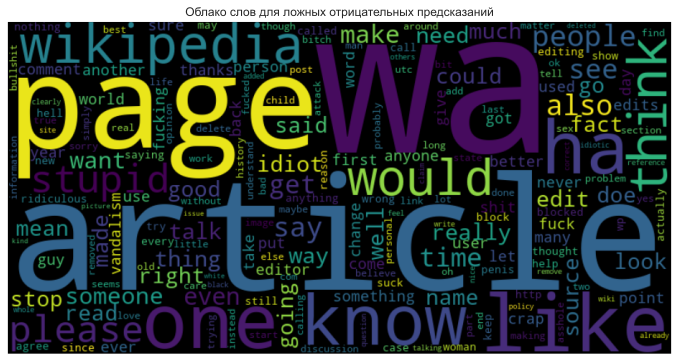

In [484]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Для ложных положительных
fp_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(fp_word_counts)
plt.figure(figsize=(12, 6))
plt.imshow(fp_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов для ложных положительных предсказаний")
plt.savefig('cloud_fp.pdf')
plt.show()

# Для ложных отрицательных
fn_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(fn_word_counts)
plt.figure(figsize=(12, 6))
plt.imshow(fn_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов для ложных отрицательных предсказаний")
plt.savefig('cloud_fn.pdf')
plt.show()


In [505]:
tfidf = TfidfVectorizer(min_df=10**(-3), max_df=0.7)
X_train_tfidf1 = tfidf.fit_transform(train_comment_lem)
tfidf.fit(train_comment_lem)
X_test_tfidf1 = tfidf.transform(test_comment_lem)
X_train_tfidf1 = normalize(X_train_tfidf1, norm='l2', axis=1)
X_test_tfidf1 = normalize(X_test_tfidf1, norm='l2', axis=1)

In [506]:
sgd = SGDClassifier(batch_size=500, step_alpha=10, step_beta=0.1, l2_coef=0.0005)
history = sgd.fit(X_train_tfidf1, y_train, w_0=np.zeros(X_train_tfidf1.shape[1]), trace=True, X_test=X_test_tfidf1, y_test=y_test)
print(np.sum(history['time']))
print(accuracy_score(y_test, sgd.predict(X_test_tfidf1)))

0.35449862480163574
0.8693170826078546


In [494]:
ngram_range = (1, 2)

vectorizer_ngramm = TfidfVectorizer(ngram_range=ngram_range)
X_train_tfidf_n = vectorizer_ngramm.fit_transform(train_comment_lem)
X_test_tfidf_n = vectorizer_ngramm.transform(test_comment_lem)

sgd = SGDClassifier(batch_size=500, step_alpha=10, step_beta=0.1, l2_coef=0.0005)
sgd.fit(X_train_tfidf_n, y_train, w_0=np.zeros(X_train_tfidf_n.shape[1]), X_test=X_test_tfidf_n, y_test=y_test)

y_pred = sgd.predict(X_test_tfidf_n)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")


Точность модели: 0.8062971561230412


In [497]:
ngram_ranges = [(1, 1), (1, 2), (1, 3), (2, 2)]

for i in ngram_ranges:
    vectorizer_ngramm = TfidfVectorizer(ngram_range=i)
    X_train_tfidf_n = vectorizer_ngramm.fit_transform(train_comment_lem)
    X_test_tfidf_n = vectorizer_ngramm.transform(test_comment_lem)
    
    sgd = SGDClassifier(batch_size=500, step_alpha=10, step_beta=0.1, l2_coef=0.0005)
    history = sgd.fit(X_train_tfidf_n, y_train, w_0=np.zeros(X_train_tfidf_n.shape[1]), trace=True, X_test=X_test_tfidf_n, y_test=y_test)
    print(np.sum(history['time']))
    
    y_pred = sgd.predict(X_test_tfidf_n)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Точность модели: {accuracy}")
    

0.9343056678771973
Точность модели: 0.8652544012381506
50.95737671852112
Точность модели: 0.8508899206809828
123.01314401626587
Точность модели: 0.8423776359063648
17.038328647613525
Точность модели: 0.799767846778874


In [546]:
ngram_ranges = [(1, 1), (1, 2), (1, 3), (2, 2)]

for i in ngram_ranges:
    vectorizer_ngramm = TfidfVectorizer(ngram_range=i)
    X_train_tfidf_n = vectorizer_ngramm.fit_transform(train_comment)
    X_test_tfidf_n = vectorizer_ngramm.transform(test_comment)
    
    sgd = SGDClassifier(batch_size=500, step_alpha=10, step_beta=0.1, l2_coef=0.0005)
    history = sgd.fit(X_train_tfidf_n, y_train, w_0=np.zeros(X_train_tfidf_n.shape[1]), trace=True, X_test=X_test_tfidf_n, y_test=y_test)
    print(np.sum(history['time']))
    
    y_pred = sgd.predict(X_test_tfidf_n)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Точность модели: {accuracy}")
    

1.1830816268920898
Точность модели: 0.8404913909847166
13.318907022476196
Точность модели: 0.81601857225769
118.42646193504333
Точность модели: 0.7998162120332752
13.477985382080078
Точность модели: 0.791642484039466
